In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from datetime import time as dtime
import time
import requests
import os
import sys
import finviz
from threading import Timer
import subprocess
import abc
import pytz
import yfinance as yf
from IPython.display import display, HTML, Image
from ordered_set import OrderedSet
import configparser
from twilio.rest import Client
import mplfinance as mpf
import backtrader as bt
from typing import List
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', 'raise')

# sys.path.append(os.path.dirname(os.getcwd())) # so we can import stockalyzer
# import finviz_data

In [2]:
class StockAlert:
    def __init__(self, ticker, signal, signal_date, close_price):
        self.ticker = ticker
        self.signal = signal
        self.date = signal_date
        self.price = close_price
        self.strategy = ""
        
        if signal == 1:
            self.strategy = "BUY"
        elif signal == -1:
            self.strategy = "SELL"
        
    def __str__(self):
        return "ALERT [%s]: %s %s at %s" % (self.date, self.strategy, self.ticker, self.price)

class PortfolioAlerter:
    def __init__(self, tickers : [str]):
        self.tickers = tickers
        self.data = TDDataFetcher(tickers).get_daily_price_history(datetime(2020, 1, 1))
        self.data["Signal"] = 0
        self.client = Client("AC069dc7540b34e4d53552123ac96f97ff", "5b460db1d5b41a9436bec81aaaa6d515")
        
        EMA20 = []
        EMA50 = []

        count = 0

        # Assuming we have same # of data points for every stock !!
        for ticker in OrderedSet(self.data.index.get_level_values(0)):
            close = self.data.loc[ticker, 'Close']
            current_EMA20 = close.ewm(span=20,adjust=False).mean()
            current_EMA50 = close.ewm(span=50,adjust=False).mean()
            EMA20.extend(current_EMA20)
            EMA50.extend(current_EMA50)


            for i in range(1,len(close)):
                if current_EMA50[i] > current_EMA20[i] and current_EMA50[i-1] < current_EMA20[i-1]:
                    if close[i] < current_EMA20[i] and close[i] < current_EMA50[i]:
        #                 data.loc[ticker].iloc[i, data.columns.get_loc("Signal")] = -1 # SELL
                        self.data.iloc[i + count * int(len(self.data)/len(tickers)), self.data.columns.get_loc("Signal")] = -1 # SELL
                elif current_EMA50[i] < current_EMA20[i] and current_EMA50[i-1] > current_EMA20[i-1]:
                    if close[i] > current_EMA20[i] and close[i] > current_EMA50[i]:
        #                 self.data.loc[ticker].iloc[i, self.data.columns.get_loc("Signal")] = 1 # BUY
                        self.data.iloc[i + count * int(len(self.data)/len(tickers)), self.data.columns.get_loc("Signal")] = 1 # BUY

            count += 1
        
        self.data["20EMA"] = EMA20
        self.data["50EMA"] = EMA50
        
#         self._computeAlerts()
        
    def computeAlerts(self):
        alerts = []
        
        for ticker in OrderedSet(self.data.index.get_level_values(0)):
            tail = self.data.loc[ticker].tail(3)
            tail = tail.loc[tail["Signal"] != 0]
            
            if tail["Signal"].any():
                row_data = tail.iloc[-1]
                alert = StockAlert(ticker, row_data["Signal"], row_data.name, row_data["Close"])
                alerts.append(str(alert))
        
        if len(alerts) > 0:
            self._sendAlerts(alerts)
                
    def _sendAlerts(self, alerts):
        alert_msg = '\n'.join(alerts)
        print(alert_msg)
        self.client.messages.create(to="+19149800095", from_="+14159388441", body=alert_msg)
        
# Methods to run the alerter:
        
# Run at a future date
def main_alert():
        SP500_TICKERS = pd.read_csv("SP500.csv")['Symbol'].tolist()[20:50]
        pa = PortfolioAlerter(SP500_TICKERS)
        pa.computeAlerts()
            
def run_at_future_date():
    while True:
        now = datetime.today()
        later = now.replace(day=now.day, hour= 2, minute=0, second=0, microsecond=0) #+ timedelta(days=1)
        delta = later - now
        secs = delta.total_seconds()

        t = Timer(secs, main_alert)
        t.start()
        
# Run infinitely every X amount of time
def run_every_time_interval():
    sleep_hours = (12) * 60 * 60

    while 1: 
        main_alert()
        dt = datetime.now() + timedelta(hours=12) 
        dt = dt.replace(minute=10)

        while datetime.now() < dt:
            time.sleep(sleep_hours)
    

In [3]:
class DataGenerator(metaclass=abc.ABCMeta):
    """
        Abstract base class for aquiring stock data
    """
    def __init__(self, tickers : [str]):
        self.tickers = tickers
        self._data = None
    
    def get_tickers(self):
        return self.tickers
        
    def has_dataframe(self):
        if self._data is None:
            return True
        return False
    
    def get_dataframe(self):
        return self._data
    
    @abc.abstractmethod
    def get_data_for(self, ticker : str):
        pass

class DataFetcher(DataGenerator):
    """
        Abstract base class for fetching historical stock data from external API's and websites
    """
    def __init__(self, tickers : [str]):
        super(DataFetcher, self).__init__(tickers)

    @abc.abstractmethod
    def get_hourly_price_history(self, start_date : datetime, end_date=date.today()):
        pass
        
    @abc.abstractmethod
    def get_daily_price_history(self, start_date : datetime, end_date=date.today()):
        """
        params:
            - start_date : datetime object
            - end_date : datetime object
        return:
            - dataframe of daily price history
        """
        pass
    
class YFDataFetcher(DataFetcher):
    def __init__(self, tickers : [str]):
        super(TDDataFetcher, self).__init__(tickers)
        
    def get_daily_price_history(self, start_date : datetime, end_date=date.today()):
        self._df = yf.download(tickers=self.tickers, start=start_date, end=end_date, interval='1d', group_by = 'ticker')
        return self._df
    
    def get_hourly_price_history(self, start_date : datetime, end_date=date.today()):
        self._df = yf.download(tickers=self.tickers, start=start_date, end=end_date, interval='1h', group_by = 'ticker')
        return self._df
    
    def get_data_for(self, ticker:str):
        return self._df[ticker]
    
    def get_ticker_objects(self):
        return [yf.Ticker(t) for t in self.tickers]
    
    def get_ticker_object(self, ticker:str):
        return yf.Ticker(ticker)
        
    def __name__(self):
        return "[Yahoo Finance] Data Fetcher"
    
class TDDataFetcher(DataFetcher):
    def __init__(self, tickers : [str], config_path = ""):
        super(TDDataFetcher, self).__init__(tickers)
        config = configparser.RawConfigParser()
        if config_path == "":
            home_dir = os.path.dirname(os.path.dirname(os.getcwd()))
#             print(home_dir)
            config.read('%s/stockalyzer/config/config.ini' % home_dir)
        else:
            config.read(config_path)
        self.__apiKey = config.get('TD', 'apiKey') # TODO : tthrow error if no key found
      
    def _get_price_history(self, start_date : datetime, end_date : datetime, params : dict, freq='daily'):
        data = []
        count = 0
        est = pytz.timezone('US/Eastern')
        fmt = '%m-%d-%Y %H:%M:%S %Z%z'
        for ticker in self.tickers:
            url = "https://api.tdameritrade.com/v1/marketdata/%s/pricehistory" % ticker
            out = requests.get(url=url,params=params).json()
#             print(out)
            if out['empty']:
                # TODO : throw error
#                 print("FALSE")
                self.tickers.remove(ticker)
                continue
            df = pd.DataFrame(out['candles']).rename(columns={'datetime':'Date','close':'Close', 'high':'High', 'low':'Low','open':'Open','volume':'Volume'}).set_index('Date')
            if freq == 'daily':
                df.index = [datetime.fromtimestamp(idx/1000).date() for idx in df.index]
            else:
                # PARSE EXTENDED HOURS DATA
                df.index = [datetime.fromtimestamp(idx/1000) for idx in df.index]
            df = df[['High','Low','Open','Close','Volume']]
            df.index = pd.to_datetime(df.index)
            if freq == 'hourly':
                df = df[df.index.isin([t for t in df.index if t.time() >= dtime(9,30) and t.time() <= dtime(16,0)])]
            data.append(df)
            count += 1
            if count % 110 == 0: # stay below transactions/second limit
                time.sleep(30)
        datas = map (data, self.tickers)
        self._df = pd.concat(data, keys=self.tickers, names=['Ticker', 'Date'])
        return self._df   
    
    def get_quotes(self):
        params = {'apikey':self.__apiKey, 'symbol':','.join(self.tickers)}
        url = "https://api.tdameritrade.com/v1/marketdata/quotes"
        out = requests.get(url=url,params=params).json()
        df = pd.DataFrame(out)
        if df.empty:
            print("FALSE")
            return None
        return df.transpose()
    
    def get_daily_price_history(self, start_date : datetime, end_date=datetime.today()):
        params = {'apikey':self.__apiKey, 'startDate':int(start_date.timestamp())*1000, 'endDate':int(end_date.timestamp())*1000, 'periodType':'year', 'frequencyType':'daily'}
        return self._get_price_history(start_date, end_date, params)
    
    def get_hourly_price_history(self, start_date : datetime, end_date=datetime.today()):
#         print(int(start_date.timestamp())*1000)
        params = {'apikey':self.__apiKey, 'startDate':int(start_date.timestamp())*1000, 'endDate':int(end_date.timestamp())*1000, 'periodType':'day', 'frequencyType':'minute', 'frequency':30}
        return self._get_price_history(start_date, end_date, params, freq="hourly")
        pass
    
    def get_data_for(self, ticker : str):
        if self.has_dataframe():
            print("[ERROR] [TDDataFetcher] fetching dataframe : never fetched pricing data. Ensure to call get_daily_price_history first.")
            return None
        return self._df.loc[ticker]
    
    def get_fundamentals(self):
        params = {'apikey':self.__apiKey, 'projection': 'fundamental', 'symbol':','.join(self.tickers)}
        url = "https://api.tdameritrade.com/v1/instruments"
        out = requests.get(url=url,params=params).json()
        df = pd.DataFrame(out)
        if df.empty:
            # TODO : throw error
            print("FALSE")
            return None
        df = df.transpose()
        fund = pd.DataFrame([data for data in df['fundamental'].values]).set_index('symbol')
        return df.drop('fundamental', axis=1).join(fund)
    
    def __name__(self):
        return "[TD Ameritrade API] Data Fetcher"
    
# class Chartable(metaclass=abc.ABCMeta):
#     def __init__(self, data, style="yahoo"):
#         self._data = data
#         self.date_str = datetime.strptime(str(data.index[0][1]), '%Y-%m-%d %H:%M:%S').strftime('%m/%d/%y') + ' - ' + datetime.strptime(str(data.index[-1][1]), '%Y-%m-%d %H:%M:%S').strftime('%m/%d/%y')
#         self.__mav_colors = mavcolors=['Brown','Orange', 'Green', 'Blue', 'Magenta', 'Brown', 'Grey']
#         self.__style = mpf.make_mpf_style(base_mpf_style=style, y_on_right=False, edgecolor='Black', facecolor='White', mavcolors=self.__mav_colors)
          
#     @abc.abstractproperty
#     def __name__(self):
#         pass
        
#     def _plot(self, data, name, type_name='candle', desc='', apds=[], mav=[], hlines=[], add_plots=[]):
# #         add_plots = [mpf.make_addplot(self.__add_mav(avg),linestyle='solid') for avg in mav]
# #         apds.append(add_plots)
#         fig, axs = mpf.plot(data, addplot=add_plots, figscale=1, figratio=(2*8,2*5.75), type=type_name, volume=True, hlines=hlines, style=self.__style, title='\n\n%s\n%s' % (name, self.date_str), returnfig=True)
        
#         for avg in mav:
#             axs[0].plot(np.arange(len(data.index)), self.__add_mav(avg))
            
#         return fig, axs
    
#     def plot_data_for(self, ticker, type_name='candle', mavs=[], signal=False):
#         """
#         ticker : str of ticker name to query
#         type_name : candle, ohlc, line
#         mavs : column names in the dataframe
#         """
#         add_plots = []
#         data = self._data.loc[ticker]
        
#         if len(mavs) > 0:
#             add_plots = [mpf.make_addplot(data[mav],linestyle='solid') for mav in mavs]
            
#         if signal:
#             signal_high = [np.nan]*len(data)
#             signal_low = [np.nan]*len(data)
#             count = 0
            
#             for index, row in data.iterrows():
#                 if row["Signal"] < 0:
#                     signal_low[count] = row["Close"] * 1.05
#                 elif row["Signal"] > 0:
#                     signal_high[count] = row["Close"] * 0.95
                    
#                 count += 1
                
#             add_plots.extend([mpf.make_addplot(signal_low,type='scatter',markersize=200,marker='v',color='r'),mpf.make_addplot(signal_high,type='scatter',markersize=200,marker='^',color='g')])
                    
#         fig, axs = self._plot(data, ticker, type_name=type_name, add_plots=add_plots)
#         return fig, axs
        
  

In [4]:


class Strategy(bt.Strategy):
    debug = False
    
    @classmethod
    def debug_on(cls):
        cls.debug = True

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
class EMACrossoverStrategy(Strategy):
    params = (('p1',20),('p2',50),)
    
#     def log(self, txt, dt=None):
#         ''' Logging function fot this strategy'''
#         dt = dt or self.datas[0].datetime.date(0)
#         print('%s, %s' % (dt.isoformat(), txt))
        
#     def debug_on(self):
#         self.debug = True
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.order = None
#         self.debug = False
                
        if self.params.p1 == -1:
            self.params.p1 = 20
        if self.params.p2 == -1:
            self.params.p2 = 50
        
        self.fast_ema = bt.indicators.EMA(self.dataclose, period=self.params.p1)
        self.slow_ema = bt.indicators.EMA(self.dataclose, period=self.params.p2)


    def next(self):
        # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])
        if self.position:
            if self.slow_ema[0] > self.fast_ema[0] and self.slow_ema[-1] < self.fast_ema[-1]:
                if self.dataclose[0] < self.fast_ema[0] and self.dataclose[0] < self.slow_ema[0]:
                    if self.debug:
                        
                        self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()
        else:
            if self.slow_ema[0] < self.fast_ema[0] and self.slow_ema[-1] > self.fast_ema[-1]:
                if self.dataclose[0] > self.fast_ema[0] and self.dataclose[0] > self.slow_ema[0]:
                    if self.debug:
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
#         else:
            # We are already in the market, look for a signal to CLOSE trades
#             if len(self) >= (self.bar_executed + 5):
#                 self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
#                 self.order = self.close()
                
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if self.debug:
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
                elif order.issell():
                    self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None
        
    @staticmethod
    def name(p1:int,p2:int):
        return f"EMA_Cross_{p1}_{p2}"
    
    def __name__(self):
        return f"EMA_Cross_{self.params.p1}_{self.params.p2}"
    
class RSIEMAStrategy(Strategy):
    params = (('p1',9),('p2',(30,70)),)
    
#     def log(self, txt, dt=None):
#         ''' Logging function fot this strategy'''
#         dt = dt or self.datas[0].datetime.date(0)
#         print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.order = None
#         self.debug = False
        
        if self.params.p1 == -1:
            self.params.p1 = 9
        if self.params.p2 == -1 or type(self.params.p2) is not tuple:
            self.params.p2 = (30,70)
        
        self.rsi = bt.indicators.RelativeStrengthIndex(self.dataclose, )
        self.ema = bt.indicators.EMA(self.dataclose, period=self.params.p1)
        self.rsi_ema = bt.indicators.RSI_EMA(self.dataclose, period=self.params.p1)
    

    def next(self):
        # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])
        if self.position:
            if self.rsi[0] > self.params.p2[1]:
                threshold = abs(self.dataclose[0] - self.ema[0]) / self.dataclose[0]
                if threshold >= .1:
                    if self.debug:
                        self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    self.order = self.sell()
        else:
            if self.rsi[0] < self.params.p2[0]:
                threshold = abs(self.dataclose[0] - self.ema[0]) / self.dataclose[0]
                if threshold <= 0.1 and threshold >= .05:
                    if self.debug:
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
#         else:
            # We are already in the market, look for a signal to CLOSE trades
#             if len(self) >= (self.bar_executed + 5):
#                 self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
#                 self.order = self.close()
                
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if self.debug:
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
                elif order.issell():
                    self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None
    
    @staticmethod
    def name(p1:int,p2:tuple):
        return f"RSI_{p2[0]}-{p2[1]}_EMA_{p1}"
    
    def __name__(self):
        return f"RSI_{self.params.p2[0]}-{self.params.p2[1]}_EMA_{self.params.p1}"

In [12]:
class StockDataManager():
     """
    For Interday trading
    
    Caution: Assumes we have the same amount of data points for all given tickers
    """
    
    def __init__(self, data, tickers : [str], start_date : datetime, debug:bool):
        self._data = data
        self.tickers = tickers
        self.start_date = start_date
        self.results = []
        self.debug = debug
        
        if not os.path.isdir('output'):
            os.makedirs('output')
            os.makedirs('output/graphs')
            os.makedirs('output/data')
        elif not os.path.isdir('output/graphs'):
            os.makedirs('output/graphs')
        if not os.path.isdir('output/data'):
            os.makedirs('output/data')
        
    @classmethod
    def load_from_data_fetcher(cls, data_fetcher : DataFetcher, start_date : datetime, intervals='d', debug=False):
        if intervals == 'd':
            data = data_fetcher.get_daily_price_history(start_date)
            tickers = data_fetcher.get_tickers()
            return cls(data, tickers, start_date, debug)
        elif intervals == 'h':
            data = data_fetcher.get_hourly_price_history(start_date)
            tickers = data_fetcher.get_tickers()
            return cls(data, tickers, start_date, debug)
        else:
            raise Exception('invalid args')
 
        
    @classmethod
    def load_from_csv(cls, path_to_csv : str, start_date : datetime, debug=False):
        data = pd.read_csv(path_to_csv)    
        tickers = list(set(data['Ticker']))
        data.set_index(['Ticker','Date'], inplace=True)
        data.index = data.index.set_levels([data.index.levels[0], pd.to_datetime(data.index.levels[1])])
        return cls(data, tickers, start_date, debug)
         
    def get_data(self):
        return self._data
    
    def get_data_for(self, ticker : str):
        try:
            return self._data.loc[ticker]
        except KeyError:
            print(f"{ticker} was not passed to the StockDataManager upon construction")
            return pd.DataFrame()
    
    def __name__(self):
        return ''.join(self.tickers)
    
    def export_data(self, path='data.csv'):
#         for ticker in self.tickers:
        self._data.to_csv(path)
    
    def run_strat(self, strategy : bt.Strategy, p1=-1, p2=-1, start_cash = 100000.0, plot=False, rfr=0.0):
        for ticker in self.tickers:
            if self.debug:
                print(f"[{ticker}-{strategy.__name__}]")
            results, pnl  = self._run_for(ticker, strategy, p1, p2, start_cash, plot, rfr)
            self.get_perf_for(ticker, results, pnl)
        
    def _run_for(self, ticker: str, strategy : bt.Strategy, p1:int, p2:int, start_cash : float, plot : bool, rfr:float):
        # Create a cerebro entity
        cerebro = bt.Cerebro(stdstats=True)
        
        # Add a strategy
        cerebro.addstrategy(strategy, p1=p1, p2=p2)
        
        if self.debug:
            strategy.debug_on()

        data = bt.feeds.PandasData(dataname=self._data.loc[ticker], timeframe=bt.TimeFrame.Days, openinterest=None)

        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=ticker)
        
        # Set our desired cash start & comission rate
        cerebro.broker.setcash(start_cash)
        cerebro.broker.setcommission(commission=0.0)
        
        # TODO: Change position sizes!
        cerebro.addsizer(bt.sizers.FixedSize, stake=1)
        
        # Analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, riskfreerate=rfr, annualize=True)
        cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Years)
        cerebro.addanalyzer(bt.analyzers.DrawDown)
        cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.NoTimeFrame, _name='returns_ann')
        cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data, _name='buyandhold')
        
        start_cash = cerebro.broker.getvalue()
        
        # Print out the starting conditions
#         print('Starting Portfolio Value: %.2f' % start_cash)
        
        # Run over everything
        result = cerebro.run()
        
        end_cash = cerebro.broker.getvalue()
        pnl = end_cash - start_cash
        
        # Print out the final result
#         print('Final Portfolio Value: %.2f' % end_cash)
#         print('PnL Value: %.2f' % pnl)

        if plot:
            fig = cerebro.plot(iplot=False)[0][0] #style='candlestick', 
            fig.savefig('%s-%s.png' % (ticker, strategy.name(p1,p2)))
            
        return result, pnl
    
    def get_perf_for(self, ticker: str, results: List[List[bt.cerebro.OptReturn]], pnl : float)->pd.DataFrame:
        stats = []
        for j in results:
#             print(j.analyzers.sharperatio.get_analysis())
    #         for i in j:
            stats.append(
                {'ticker': f'{ticker}',
                 'strategy': j.__name__(),
                 'pnl': '{0:.2f}'.format(pnl),
                 'sharpe_ratio': j.analyzers.sharperatio.get_analysis()['sharperatio'],
                 'max_drawdown': '{0:.2f}%'.format(j.analyzers.drawdown.get_analysis()['max']['drawdown']*100),
                 'returns_ann': '{0:.4f}%'.format(list(j.analyzers.returns_ann.get_analysis().values())[0] * 100),
                 'buy_and_hold_return': '{0:.4f}%'.format(list(j.analyzers.buyandhold.get_analysis().values())[0] * 100),
                 'vwr': j.analyzers.vwr.get_analysis()['vwr'],
                }
            )
        df = pd.DataFrame(stats)
#         df.set_index('ticker', inplace=True)
        df.set_index(['ticker','strategy'], inplace=True)
        self.results.append(df)
                
    def get_results(self, to_print=False, ipython=False, graphs=False):
        self.results_df = pd.concat(self.results)
        if to_print:
            if ipython:
                display(self.results_df)
            else:
                print(self.results_df)
        
        if graphs:
            for strat, row in self.results_df.iterrows():
                file = '%s-%s.png'% (row.name[0], strat[1])
                display(file)
                if os.path.exists(file):
                    print(file)
                    display(Image(filename=file))
                    
        self.results_df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)
        return self.results_df

In [6]:

class Stock:
    
    def __init__(self, ticker, **kwargs):
        
        self.ticker = ticker
        
        # Backtrader
        self.strategy_perf = kwargs.get('strategy_perf',None)
        
        # TDAmeritrade
        self.fundamentals = kwargs.get('fundamentals',dict())
        
        # FINVIZ
        self.finviz = kwargs.get('finviz',False)
        if self.finviz:
            self.stats = finviz.get_stock(self.ticker)
            self.news = finviz.get_news(self.ticker)
            self.ratings = finviz.get_analyst_price_targets(self.ticker,last_ratings=8)
            self.insider_trades = finviz.get_insider(self.ticker)

            self.company_name = self.stats['Company']
            self.sector = self.stats['Sector'] 
            self.industry = self.stats['Industry']
            self.country = self.stats['Country']
            self.index = self.stats['Index']
            
        self.yahoo = kwargs.get('yahoo',False)
        if self.yahoo:
            self.yf_ticker = yf.Ticker(self.ticker)

            
        # Basic info
#         self.sector = kwargs.get('sector',self.sector)
#         self.industry = kwargs.get('industry',self.industry)
        
        
    def get_perf(self):
        return self.strategy_perf
    
    def get_fundamentals(self):
        return self.fundamentals
    
    def get_fundamental(self, metric:str):
        return self.fundamentals[metric]
    
    def __str__(self):
        return f"{self.ticker}"
        
#     @classmethod
#     def load_stocks_from(cls, tickers:[str], strat_perf:pd.DataFrame, fundamentals:dict):            
#         return [cls(t, strat_perf=strat_perf.loc[t], fundamentals=fundamentals.loc[t].to_dict()) for t in tickers]
        
        
        
        
        

In [7]:
fetcher = TDDataFetcher(['NVDA','AMD'])
to_plot = debug = False
# data = fetcher.get_hourly_price_history(datetime(2017, 6, 1))
# fetcher = TDDataFetcher(tickers)
sm = StockDataManager.load_from_data_fetcher(fetcher, datetime(2017, 6, 1), intervals='h',debug=debug)
#     sm = StockDataManager.load_from_csv('data.csv', datetime(2019, 6, 1))
sm.run_strat(EMACrossoverStrategy, p1=20, p2=80, plot=to_plot)
sm.run_strat(RSIEMAStrategy, p1=9, p2=(30,70), plot=to_plot)
strat_perf = sm.get_results(to_print=True,ipython=True,graphs=to_plot)
#     stocks = [Stock(t, strategy_perf=strat_perf.loc[t], fundamentals=fundamentals.loc[t], finviz=True) for t in sm.tickers]
strat_perf

,,pnl,sharpe_ratio,max_drawdown,returns_ann,buy_and_hold_return,vwr
ticker,strategy,,,,,,
NVDA,EMA_Cross_20_80,59.27,0.669711,15.11%,0.0592%,30.2392%,0.024016
AMD,EMA_Cross_20_80,-10.43,-0.697928,2.53%,-0.0104%,0.3133%,-0.004554
NVDA,RSI_30-70_EMA_9,126.74,1.820778,15.08%,0.1267%,30.2392%,0.052744
AMD,RSI_30-70_EMA_9,1.00,0.069953,2.60%,0.0010%,0.3133%,0.000425


pnl  sharpe_ratio max_drawdown returns_ann  \
ticker strategy                                                         
NVDA   RSI_30-70_EMA_9  126.74      1.820778       15.08%     0.1267%   
       EMA_Cross_20_80   59.27      0.669711       15.11%     0.0592%   
AMD    RSI_30-70_EMA_9    1.00      0.069953        2.60%     0.0010%   
       EMA_Cross_20_80  -10.43     -0.697928        2.53%    -0.0104%   

                       buy_and_hold_return       vwr  
ticker strategy                                       
NVDA   RSI_30-70_EMA_9            30.2392%  0.052744  
       EMA_Cross_20_80            30.2392%  0.024016  
AMD    RSI_30-70_EMA_9             0.3133%  0.000425  
       EMA_Cross_20_80             0.3133% -0.004554

In [8]:
strat_perf

pnl  sharpe_ratio max_drawdown returns_ann  \
ticker strategy                                                         
NVDA   RSI_30-70_EMA_9  126.74      1.820778       15.08%     0.1267%   
       EMA_Cross_20_80   59.27      0.669711       15.11%     0.0592%   
AMD    RSI_30-70_EMA_9    1.00      0.069953        2.60%     0.0010%   
       EMA_Cross_20_80  -10.43     -0.697928        2.53%    -0.0104%   

                       buy_and_hold_return       vwr  
ticker strategy                                       
NVDA   RSI_30-70_EMA_9            30.2392%  0.052744  
       EMA_Cross_20_80            30.2392%  0.024016  
AMD    RSI_30-70_EMA_9             0.3133%  0.000425  
       EMA_Cross_20_80             0.3133% -0.004554

,,pnl,sharpe_ratio,max_drawdown,returns_ann,buy_and_hold_return,vwr
ticker,strategy,,,,,,
NVDA,EMA_Cross_20_80,338.24,0.944103,14.89%,0.3377%,348.1550%,0.052828
AMD,EMA_Cross_20_80,50.76,0.628118,2.02%,0.0507%,611.8222%,0.008523
NVDA,RSI_30-70_EMA_9,186.27,0.918021,5.83%,0.1861%,348.1550%,0.029698
AMD,RSI_30-70_EMA_9,17.34,0.896781,1.23%,0.0173%,611.8222%,0.003005


'NVDA-EMA_Cross_20_80.png'

NVDA-EMA_Cross_20_80.png


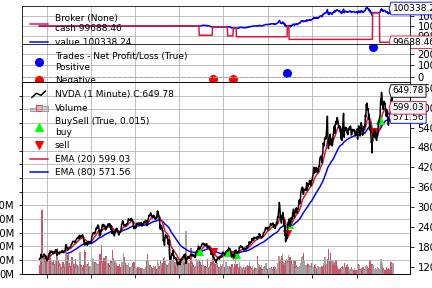

'AMD-EMA_Cross_20_80.png'

AMD-EMA_Cross_20_80.png


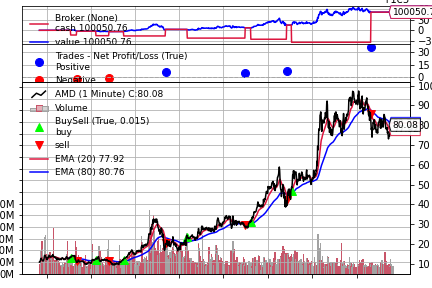

'NVDA-RSI_30-70_EMA_9.png'

NVDA-RSI_30-70_EMA_9.png


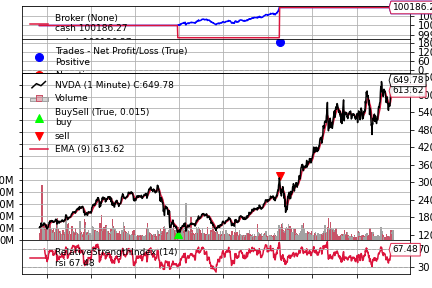

'AMD-RSI_30-70_EMA_9.png'

AMD-RSI_30-70_EMA_9.png


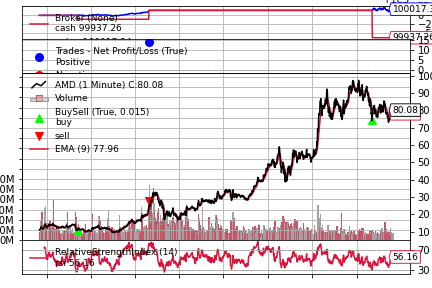

In [9]:
# %%time
def main(tickers=[], debug=False, to_plot=False):
    fetcher = TDDataFetcher(tickers)
    fundamentals = fetcher.get_fundamentals()
    sm = StockDataManager.load_from_data_fetcher(fetcher, datetime(2017, 6, 1), debug=debug)
#     sm = StockDataManager.load_from_csv('data.csv', datetime(2019, 6, 1))
    sm.run_strat(EMACrossoverStrategy, p1=20, p2=80, plot=to_plot)
    sm.run_strat(RSIEMAStrategy, p1=9, p2=(30,70), plot=to_plot)
    strat_perf = sm.get_results(to_print=True,ipython=True,graphs=to_plot)
    stocks = [Stock(t, strategy_perf=strat_perf.loc[t], fundamentals=fundamentals.loc[t], finviz=True) for t in sm.tickers]
    return stocks, sm
# start = time.time()
tickers = ["NVDA", "AMD"]
stocks, sm = main(tickers=tickers, to_plot=True)
# end = time.time()
# print('{0:.4f} seconds'.format(end - start))

# TODO
## Cibelli:
- research successful strategy
## Me:
- Yahoo Fin Split & Adj Close data
- Hourly data
- Test capacity of algo to see how many tickers can run in time period (ideal 30 - 60 mins)
- Perf:
        - Time per trade
        - 

# TODO:
### - optstrategy --> more params, grid search
### Fix load_from_csv start_time param
## Data:
- Split & Dividend Data

# NEXT:
### - Screener Infrastructure / Stock Universe

# AI/ML:
### - create model to aggregate all info for a given stock, such as fundamentals, strategy performance, news...
### - create NN using ^features^ 

In [10]:
def get_perf(results: List[List[bt.cerebro.OptReturn]])->pd.DataFrame:
    stats = []
    for i in results:
        for j in i:
            stats.append(
                {'strategy': f'SMA_Cross_{j.params.fast}_{j.params.slow}',
                 'sharpe_ratio': j.analyzers.sharperatio.get_analysis()['sharperatio'],
                 'return': '{0:.2f}%'.format(list(j.analyzers.timereturn.get_analysis().values())[0] * 100),
                 'buy_and_hold': '{0:.2f}%'.format(list(j.analyzers.buyandhold.get_analysis().values())[0] * 100),
                 'vwr': j.analyzers.vwr.get_analysis()['vwr'],
                }
            )
    df = pd.DataFrame(stats)
    df.sort_values(by='sharpe_ratio', ascending=False, inplace=True)
    df.set_index('strategy', inplace=True)
    return df

def grid_search(data_feed: bt.feeds.PandasData, fast: List[int], slow: List[int])->List[List[bt.cerebro.OptReturn]]:
    cerebro = bt.Cerebro()
    cerebro.optstrategy(EMACrossoverStrategy, fast=fast, slow=slow)
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(10000.0)
    cerebro.broker.setcommission(commission=0.0004)  # Binance Swap taker fee

    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
    cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    return cerebro.run()

# data_feed = bt.feeds.PandasData(dataname=sm._data.loc['PYPL'], timeframe=bt.TimeFrame.Days, openinterest=None)
# results = grid_search(data_feed, fast=[32, 64], slow=[256, 512])

In [16]:
# YAHOO FINANCEDATA
tickers = ['AAPL','NVDA']
yf_tickers = [yf.Ticker(t) for t in tickers]
data = yf.download(tickers=tickers, start=datetime(2010, 6, 1), interval='1d', group_by = 'ticker')
data['AAPL']

[*********************100%***********************]  2 of 2 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-01,9.274643,9.497857,9.248571,9.315357,8.010303,876472800
2010-06-02,9.447857,9.457143,9.297500,9.426786,8.106121,688548000
2010-06-03,9.470714,9.483929,9.300357,9.397143,8.080631,650106800
2010-06-04,9.221786,9.353571,9.093929,9.141429,7.860740,758304400
2010-06-07,9.224643,9.255357,8.948214,8.962143,7.706572,886942000
2010-06-08,9.044286,9.064286,8.773214,8.904643,7.657127,1000770400
2010-06-09,8.981071,8.996429,8.660357,8.685714,7.468872,854630000
2010-06-10,8.744286,8.963571,8.650000,8.946786,7.693367,776356000
2010-06-11,8.865357,9.066429,8.834643,9.053929,7.785498,545759200


In [ ]:
sm._data.loc['AAPL']

In [ ]:
(data['AAPL'].round(3) - sm._data.loc['AAPL']).max()

In [ ]:
int(datetime(2015,6,1).timestamp())*1000

In [ ]:
# # General STOCK SCREENER:
# output_file = "screener_results.csv"
# result = subprocess.run([sys.executable, "finviz_screener.py", "--table=Valuation",f"--output_name={output_file.split('.')[0]}", "--save=True"], capture_output=True, text=True)
# pd.read_csv(output_file)